# QEP Regression with a Spectral Mixture Kernel

## Introduction

This example shows how to use a `SpectralMixtureKernel` module on an `ExactQEP` model. This module is designed for

- When you want to use exact inference (e.g. for regression)
- When you want to use a more sophisticated kernel than RBF

The Spectral Mixture (SM) kernel was invented and discussed in [Wilson et al., 2013](https://arxiv.org/pdf/1302.4245.pdf).

In [1]:
import math
import torch
import qpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In the next cell, we set up the training data for this example. We'll be using 15 regularly spaced points on [0,1] which we evaluate the function on and add Gaussian noise to get the training labels.

In [2]:
train_x = torch.linspace(0, 1, 15)
train_y = torch.sin(train_x * (2 * math.pi))

## Set up the model

The model should be very similar to the `ExactQEP` model in the [simple regression example](./Simple_QEP_Regression.ipynb).

The only difference is here, we're using a more complex kernel (the `SpectralMixtureKernel`). This kernel requires careful initialization to work properly. To that end, in the model `__init__` function, we call

```
self.covar_module = qpytorch.kernels.SpectralMixtureKernel(n_mixtures=4)
self.covar_module.initialize_from_data(train_x, train_y)
```

This ensures that, when we perform optimization to learn kernel hyperparameters, we will be starting from a reasonable initialization.

In [3]:
POWER = 1.0
class SpectralMixtureQEPModel(qpytorch.models.ExactQEP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralMixtureQEPModel, self).__init__(train_x, train_y, likelihood)
        self.power = torch.tensor(POWER)
        self.mean_module = qpytorch.means.ConstantMean()
        self.covar_module = qpytorch.kernels.SpectralMixtureKernel(num_mixtures=4)
        self.covar_module.initialize_from_data(train_x, train_y)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return qpytorch.distributions.MultivariateQExponential(mean_x, covar_x, power=self.power)

    
likelihood = qpytorch.likelihoods.QExponentialLikelihood(power=torch.tensor(POWER))
model = SpectralMixtureQEPModel(train_x, train_y, likelihood)

In the next cell, we handle using Type-II MLE to train the hyperparameters of the q-exponential process.
The spectral mixture kernel's hyperparameters start from what was specified in `initialize_from_data`.

See the [simple regression example](./Simple_QEP_Regression.ipynb) for more info on this step.

In [4]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 100

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for QEPs - the marginal log likelihood
mll = qpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

Iter 1/100 - Loss: 1.536
Iter 2/100 - Loss: 1.511
Iter 3/100 - Loss: 1.479
Iter 4/100 - Loss: 1.450
Iter 5/100 - Loss: 1.418
Iter 6/100 - Loss: 1.383
Iter 7/100 - Loss: 1.348
Iter 8/100 - Loss: 1.312
Iter 9/100 - Loss: 1.277
Iter 10/100 - Loss: 1.241
Iter 11/100 - Loss: 1.206
Iter 12/100 - Loss: 1.172
Iter 13/100 - Loss: 1.139
Iter 14/100 - Loss: 1.105
Iter 15/100 - Loss: 1.069
Iter 16/100 - Loss: 1.032
Iter 17/100 - Loss: 0.994
Iter 18/100 - Loss: 0.956
Iter 19/100 - Loss: 0.919
Iter 20/100 - Loss: 0.884
Iter 21/100 - Loss: 0.850
Iter 22/100 - Loss: 0.817
Iter 23/100 - Loss: 0.783
Iter 24/100 - Loss: 0.748
Iter 25/100 - Loss: 0.712
Iter 26/100 - Loss: 0.677
Iter 27/100 - Loss: 0.641
Iter 28/100 - Loss: 0.607
Iter 29/100 - Loss: 0.573
Iter 30/100 - Loss: 0.540
Iter 31/100 - Loss: 0.507
Iter 32/100 - Loss: 0.474
Iter 33/100 - Loss: 0.441
Iter 34/100 - Loss: 0.407
Iter 35/100 - Loss: 0.374
Iter 36/100 - Loss: 0.342
Iter 37/100 - Loss: 0.310
Iter 38/100 - Loss: 0.278
Iter 39/100 - Loss: 0

Now that we've learned good hyperparameters, it's time to use our model to make predictions. The spectral mixture kernel is especially good at extrapolation. To that end, we'll see how well the model extrapolates past the interval `[0, 1]`.

In the next cell, we plot the mean and confidence region of the q-exponential process model. The `confidence_region` method is a helper method that returns 2 standard deviations above and below the mean.

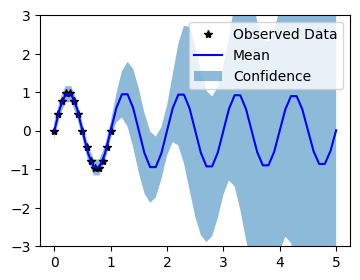

In [5]:
# Test points every 0.1 between 0 and 5
test_x = torch.linspace(0, 5, 51)

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), qpytorch.settings.fast_pred_var():
    # Make predictions
    observed_pred = likelihood(model(test_x))

    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region(rescale=True)
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])